# Overview

**[Predicting Heart Disease](https://www.kaggle.com/competitions/playground-series-s6e2/overview)**

Target은 Heart Disease

Learning Type: Binary Classification

Metric: Area under curve

In [1]:
import os
from pathlib import Path

In [2]:
data_path = Path('data')

if not os.path.exists(data_path / 'train.csv'):
    !kaggle competitions download -c playground-series-s6e2
    !unzip playground-series-s6e2.zip -d data
    !rm playground-series-s6e2.zip

In [3]:
import mllabs
mllabs.__version__

'0.3.0'

In [4]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline

from mllabs import Experimenter, Connector
from mllabs.processor import PolarsLoader, PandasConverter
from mllabs.processor import CategoricalConverter
from mllabs.collector import MetricCollector, ModelAttrCollector

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from IPython.display import Markdown

In [5]:
loader = make_pipeline(
    PolarsLoader(predefined_types={'id': pl.Int64}),
    PandasConverter(index_col='id')
)
train_file = data_path / 'train.csv'
test_file = data_path / 'test.csv'
df_train = loader.fit_transform([train_file])
df_data_spec = loader[0].df_type_.join(
    pd.Series(loader[0].pl_type_, name = 'actual_dtype')
)
df_data_spec

,min,max,na,count,n_unique,dtype,f32,i32,i16,i8,actual_dtype
feature,,,,,,,,,,,
Age,29.0,77.0,0.0,630000.0,42.0,Int64,True,True,True,True,Int8
BP,94.0,200.0,0.0,630000.0,66.0,Int64,True,True,True,False,Int16
Chest pain type,1.0,4.0,0.0,630000.0,4.0,Int64,True,True,True,True,Int8
Cholesterol,126.0,564.0,0.0,630000.0,150.0,Int64,True,True,True,False,Int16
EKG results,0.0,2.0,0.0,630000.0,3.0,Int64,True,True,True,True,Int8
Exercise angina,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
FBS over 120,0.0,1.0,0.0,630000.0,2.0,Int64,True,True,True,True,Int8
Heart Disease,NaN,NaN,0.0,630000.0,2.0,String,False,False,False,False,Categorical
Max HR,71.0,202.0,0.0,630000.0,93.0,Int64,True,True,True,False,Int16


# Data Spec.

원본 데이터셋을 기반으로 Competition 용으로 인공적으로 생성한 데이터인데,

이 문제에 접근한 시점에서 원본 데이터가 올라온 페이지가

사라져서 정확한 스펙을 알수가 없다.

데이터에 대한 지식이 없어 GPT를 활용해서 대략의 스펙 조사.

변수의 대략의 스펙을 뽑아 보자.

In [6]:
print(df_data_spec.loc[:, ['min', 'max', 'n_unique', 'actual_dtype']].to_markdown())

| feature                 |   min |      max |   n_unique | actual_dtype   |
|:------------------------|------:|---------:|-----------:|:---------------|
| Age                     |    29 |     77   |         42 | Int8           |
| BP                      |    94 |    200   |         66 | Int16          |
| Chest pain type         |     1 |      4   |          4 | Int8           |
| Cholesterol             |   126 |    564   |        150 | Int16          |
| EKG results             |     0 |      2   |          3 | Int8           |
| Exercise angina         |     0 |      1   |          2 | Int8           |
| FBS over 120            |     0 |      1   |          2 | Int8           |
| Heart Disease           |   nan |    nan   |          2 | Categorical    |
| Max HR                  |    71 |    202   |         93 | Int16          |
| Number of vessels fluro |     0 |      3   |          4 | Int8           |
| ST depression           |     0 |      6.2 |         66 | Float32        |

## Type from GPT

| Feature                  | ML_Type      |
|--------------------------|-------------|
| Age                      | Numeric     |
| BP                       | Numeric     |
| Cholesterol              | Numeric     |
| Max HR                   | Numeric     |
| ST depression            | Numeric     |
| Chest pain type          | Categorical |
| EKG results              | Categorical |
| Exercise angina          | Categorical |
| FBS over 120             | Categorical |
| Sex                      | Categorical |
| Thallium                 | Categorical |
| Number of vessels fluro  | Ordinal     |
| Slope of ST              | Ordinal     |
| Heart Disease            | Target      |
| id                       | Identifier  |

**일단은 위 형식으로 따라가고, 타입 조정의 요소가 있을 때, 변경**

In [7]:
df_test = loader.transform([test_file])

Thallium 이 원소명이라 수치형으로 생각이 됐지만, GPT는 코드라고 응답했고,  범주형이라고 하여, 빈도 조사해 보자.

In [8]:
df_train['Thallium'].value_counts()

Thallium
3    372286
7    246748
6     10966
Name: count, dtype: int64

In [9]:
target = 'Heart Disease'
X_cont = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
X_nom = ['Chest pain type', 'EKG results', 'Thallium']
X_ord = ['Number of vessels fluro', 'Slope of ST']
X_bin = ['Exercise angina', 'FBS over 120', 'Sex']
X_all = X_cont + X_nom + X_ord + X_bin
print('Var. no', df_data_spec.shape[0])
print('Cont.', len(X_cont))
print('Nom.', len(X_nom))
print('Ord.', len(X_ord))
print('Bin.', len(X_bin))

Var. no 15
Cont. 5
Nom. 3
Ord. 2
Bin. 3


In [10]:
display(df_train.head(5))
df_train.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


(630000, 14)

In [11]:
display(df_test.head(5))
df_test.shape

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
id,,,,,,,,,,,,,
630000,58,1,3,120,288,0,2,145,1,0.8,2,3,3
630001,55,0,2,120,209,0,0,172,0,0.0,1,0,3
630002,54,1,4,120,268,0,0,150,1,0.0,2,3,7
630003,44,0,3,112,177,0,0,168,0,0.9,1,0,3
630004,43,1,1,138,267,0,0,163,0,1.8,2,0,7


(270000, 13)

# 평가셋과 학습셋의 차이 파악

평가셋에 대한 정보가 딱히 없다. Train과 Test의 분포의 차이를 Train과 Test를 분류하는 모델을 만들어 살펴 보고,

피쳐의 특성을 파악할 때, Train과 Test의 분포 차이를 봐야 할 지를 정해 놓고, 속성별 파악을 하자.

In [12]:
df_is_test = pd.concat([
    df_train.drop(columns = [target]).assign(is_test=0),
    df_test.assign(is_test=1)
])
display(df_is_test.head())
df_is_test['is_test'].value_counts()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,is_test
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,0
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,0


is_test
0    630000
1    270000
Name: count, dtype: int64

In [13]:
if os.path.exists('exp/is_test'):
    e_is_test = Experimenter.load('exp/is_test', df_is_test)
else:
    e_is_test = Experimenter.create(
        df_is_test, 'exp/is_test', title = 'Train/Test셋 여부를 구분', sp = StratifiedShuffleSplit(n_splits=1, random_state = 1), splitter_params = {'y': 'is_test'}
    )
    if e_is_test.status == 'closed':
        e_is_test.reopen()
Markdown(
    e_is_test.desc_spec()
)

Loaded: 3 node(s), 2 group(s), 1 fold(s)


## Train/Test셋 여부를 구분

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1)` |
| **Inner Splitter (sp_v)** | None |
| **Splitter Params** | `{y='is_test'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [15]:
import lightgbm as lgb
e_is_test.add_collector(
    MetricCollector(
        'AUC', Connector(edges = {'y': [(None, 'is_test')]}), slice(-1, None), roc_auc_score, include_train = True
    )
)
e_is_test.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance', Connector(processor = lgb.LGBMClassifier), 'feature_importances'
    )
)
e_is_test.set_grp('clf', role = 'head', edges = {'y': [(None, 'is_test')]}, method = 'predict_proba')
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_all)]}, 
    params={'verbose': -1, 'categorical_features': X_nom}
)

Collect 1/1 (100%) Node 0
Collect 1/1 (100%) Node 0


{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x770e6689f020>}

In [16]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 0/1 (0%) > Node 0/1 (0%)[lgb1] Exp error at fold 0: LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name
Exp 1/1 (100%) lgb1 1/1 (100%)
Experimentation complete: 0/1 node(s), 1 error(s): ['lgb1']


[LightGBM] [Fatal] categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


In [17]:
e_is_test.show_error_nodes()

[lgb1] LightGBMError: categorical_feature is not a number,
if you want to use a column name,
please add the prefix "name:" to the column name


LGBMClassifier에 categorical_feature에 수치형 타입을 쓸 수 없으니, 범주형으로 변환하는 과정을 적용합니다.

In [18]:
e_is_test.set_grp('pre', role = 'stage', method = 'transform')

{'result': 'new',
 'grp': <mllabs._pipeline.PipelineGroup at 0x770e644eeae0>,
 'affected_nodes': []}

In [19]:
e_is_test.set_node(
    'n2c', grp='pre', processor=CategoricalConverter, edges = {'X': [(None, X_nom)]}
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x770e644ee4e0>}

In [20]:
e_is_test.set_node(
    'lgb1', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ['n2c__' + i for i in X_nom]}, method = 'predict_proba', exist = 'replace'
)

{'result': 'update',
 'affected_nodes': [],
 'old_obj': <mllabs._pipeline.PipelineNode at 0x770e6689f020>,
 'obj': <mllabs._pipeline.PipelineNode at 0x770e644ee510>}

In [21]:
Markdown(
    e_is_test.desc_pipeline()
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_clf["clf"]
        node_lgb1["lgb1"]
        style node_lgb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [22]:
Markdown(
    e_is_test.desc_node('lgb1', show_params=True)
)

```mermaid
graph TD

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph node_lgb1["clf/lgb1"]
        lgb1_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>LGBMClassifier</td></tr><tr><td align='left'><b>method</b></td><td align='left'>predict_proba</td></tr><tr><td align='left'><b>verbose</b></td><td align='left'>-1</td></tr><tr><td align='left'><b>categorical_features</b></td><td align='left'>['n2c__Chest pain type', 'n2c__EKG re...</td></tr></table>"]
    end
    style node_lgb1 fill:#ffcdd2,stroke:#c62828,stroke-width:3px

    subgraph node_n2c["pre/n2c"]
        n2c_info["<table><tr><td align='left'><b>processor</b></td><td align='left'>CategoricalConverter</td></tr><tr><td align='left'><b>method</b></td><td align='left'>transform</td></tr></table>"]
    end
    style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px

    DataSource -->|X,y| node_lgb1
    DataSource --> node_n2c
    node_n2c --> node_lgb1
```

**Path from DataSource to 'clf/lgb1' (2 path(s) found)**

### Edges

| Key | Node | Var |
|-----|------|-----|
| X | Data Source | `['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 'Exercise angina', 'FBS over 120', 'Sex']` |
| X | pre/n2c | * |
| y | Data Source | `is_test` |

In [23]:
e_is_test.build()

Building 1 node(s)
Build 1/1 (100%) n2c 1/1 (100%)
Build complete: 1 node(s)


In [24]:
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb1 1/1 (100%) 100/100 (100%)
Experimentation complete: 1 node(s)


In [25]:
e_is_test.get_obj_vars('lgb1', 0)

[(['Age',
   'BP',
   'Cholesterol',
   'Max HR',
   'ST depression',
   'Exercise angina',
   'FBS over 120',
   'Sex',
   'n2c__Chest pain type',
   'n2c__EKG results',
   'n2c__Thallium'],
  ['lgb1__is_test_0', 'lgb1__is_test_1'],
  [0])]

In [26]:
e_is_test.collectors['AUC'].get_metrics_agg(None)[0]

,valid,train_sub
lgb1,0.503313,0.542511


In [27]:
e_is_test.set_node(
    'lgb2', grp='clf', processor=lgb.LGBMClassifier , edges = {'X': [(None, X_cont + X_bin), ('n2c', None)]}, 
    params={'verbose': -1, 'categorical_features': ['n2c__' + i for i in X_nom], 'n_estimators': 1000}, method = 'predict_proba'
)
e_is_test.exp()

Experimenting 1 node(s)
Exp 1/1 (100%) lgb2 1/1 (100%) 1000/1000 (100%)
Experimentation complete: 1 node(s)


In [28]:
e_is_test.pipeline.compare_nodes(
    e_is_test.pipeline.get_node_names('lgb*')
)['LGBMClassifier'].fillna('default').join(
    e_is_test.collectors['AUC'].get_metrics_agg(None)[0].stack().rename('AUC').to_frame().unstack()
)

params       AUC          
     n_estimators     valid train_sub
lgb1      default  0.503313  0.542511
lgb2       1000.0  0.504157  0.638938

In [29]:
e_is_test.close_exp()

Finalize 'n2c'
Finalize 'lgb1'
Finalize 'lgb2'


입력 속성으로 LGBMClassifier로 Train과 Test를 구분하는 모델을 만든 결과

Train과 Test를 구분하기에는 어렵다는 것을 확인할 수 있었습니다.

따라서 Train과 Test의 입력 Feature의 차이점 분석은 유의미한 정보를 얻을 가능성은 적습니다.

우선 순위를 미루고, score상 Validation 결과와 차이가 크다면, 분석을 고려합니다.

여기서 LGBM에서의 feature importance는 의미는 없지만, 기능을 보이기 위해 참고적으로 출력합니다.

In [30]:
e_is_test.collectors['lgb_feature_importance'].get_attrs()['lgb2']

[[Age                     5085
  BP                      4413
  Cholesterol             6503
  Max HR                  5869
  ST depression           3974
  Exercise angina          701
  FBS over 120             366
  Sex                      678
  n2c__Chest pain type     546
  n2c__EKG results         940
  n2c__Thallium            925
  Name: importance, dtype: int32]]

# Exploratory Data Analysis

## Target: Heart Disease

In [31]:
df_train[target].value_counts().pipe(
    lambda x: pd.concat([x, (x / x.sum()).rename('ratio')], axis=1)
)

,count,ratio
Heart Disease,,
Absence,347546,0.55166
Presence,282454,0.44834


Absence(55.2%) vs Presence(44.8%)로 약한 불균형. Stratified split으로 대응 가능하며 별도의 imbalance 처리는 우선 불필요.

## Continuous Variable

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
X_cont

['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

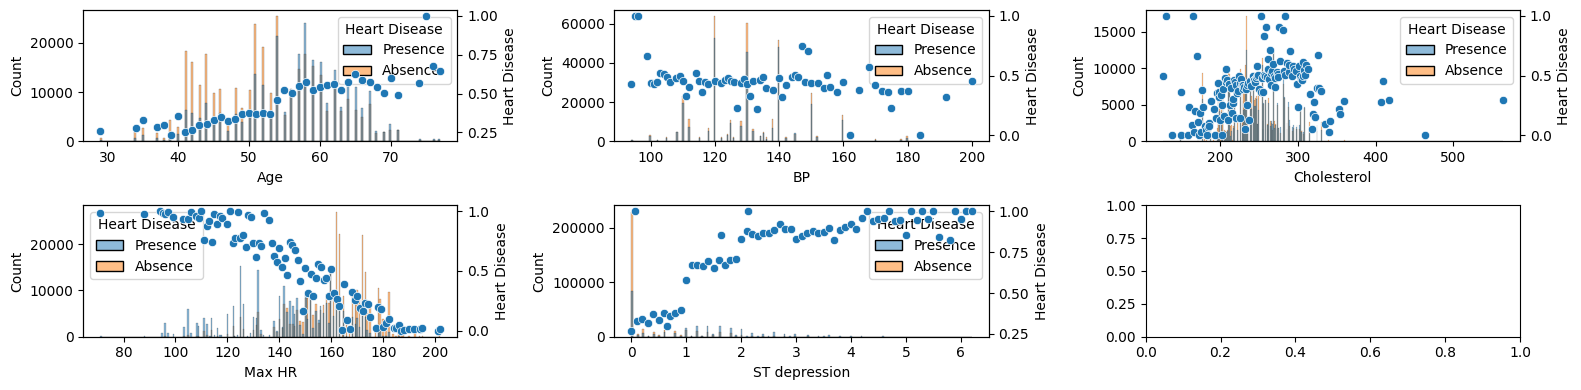

In [34]:
_, axes = plt.subplots(2, 3, figsize = (16, 4))
for i, ax in zip(X_cont, axes.flatten()):
    sns.histplot(df_train, x = i, ax = ax, hue = target)
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean()).to_frame().pipe(
        lambda x: sns.scatterplot(x, x = i, y = target, ax = ax.twinx())
    )
plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score

df_train[X_cont].apply(
    lambda x: roc_auc_score(df_train[target], x)
).apply(
    lambda x: max(x, 1 - x)
).rename('AUC').sort_values(ascending = False).to_frame().T

,Max HR,ST depression,Age,Cholesterol,BP
AUC,0.755908,0.733678,0.625654,0.552904,0.500486


Max HR(0.756), ST depression(0.734)이 단독 예측력 1~2위. Age, Cholesterol은 중간 수준. BP(0.500)는 단독으로는 사실상 무의미.

In [36]:
df_train[X_cont].corr(method='spearman').unstack().rename('corr').reset_index().query('level_0 < level_1').pipe(
    lambda x: x.iloc[np.argsort(-x['corr'].abs())]
)

,level_0,level_1,corr
19,Max HR,ST depression,-0.231181
4,Age,ST depression,0.106459
3,Age,Max HR,-0.099570
13,Cholesterol,Max HR,-0.053541
14,Cholesterol,ST depression,0.048520
2,Age,Cholesterol,0.022749
7,BP,Cholesterol,-0.003558
1,Age,BP,-0.002731
8,BP,Max HR,0.001367
9,BP,ST depression,-0.001015


연속형 변수 간 상관관계는 전반적으로 낮음(최대 -0.231). 다중공선성 우려는 적으며 변수 간 독립성이 높은 편.

In [37]:
df_st_freq = pd.concat([
    df_train['ST depression'].value_counts(),
    df_train.groupby(i)[target].agg(lambda x: (x == 'Presence').mean())
], axis=1)
df_st_freq

,count,Heart Disease
ST depression,,
0.00,314939,0.269332
1.20,29269,0.668591
1.00,28647,0.581492
1.60,28395,0.701215
1.40,27146,0.697561
...,...,...
4.70,4,1.000000
5.10,2,1.000000
2.12,1,1.000000


In [38]:
from scipy.stats import spearmanr
spearmanr(df_st_freq['count'], df_st_freq[target])

SignificanceResult(statistic=np.float64(-0.6640987899506298), pvalue=np.float64(1.2118203419747983e-09))

ST depression 값의 빈도와 Heart Disease 비율 간 강한 음의 상관(ρ=-0.664, p≈0). 빈도가 낮은(희귀한) 값일수록 Heart Disease 비율이 높음. 수치형 그대로 활용 가능.

## Categorical Variables

In [39]:
df_train[X_bin + X_ord + X_nom].nunique().rename('n_unique').to_frame().T

,Exercise angina,FBS over 120,Sex,Number of vessels fluro,Slope of ST,Chest pain type,EKG results,Thallium
n_unique,2,2,2,4,3,4,3,3


### Chi2-Test

In [40]:
from scipy.stats import chi2_contingency

df_train[X_bin + X_ord + X_nom].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target]))[1]
).sort_values(ascending = True)

Exercise angina             0.000000e+00
Sex                         0.000000e+00
Number of vessels fluro     0.000000e+00
Slope of ST                 0.000000e+00
EKG results                 0.000000e+00
Chest pain type             0.000000e+00
Thallium                    0.000000e+00
FBS over 120               2.280820e-156
dtype: float64

모든 범주형 변수가 Target과 유의미한 연관성(p≈0). FBS over 120만 상대적으로 p값이 높아 예측력이 약함.

### Information gain

In [41]:
y_prob = df_train[target].value_counts(normalize = True)
H_target = -y_prob.dot(np.log(y_prob))

pd.Series({
    i: H_target - pd.crosstab(index = df_train[i], columns = df_train[target], normalize = 'index').apply(
        lambda x: -x.dot(np.log(x)), axis = 1
    ).dot(df_train[i].value_counts(normalize = True)) for i in X_bin + X_ord + X_nom
}, name = 'IG').sort_values(ascending = False)

Thallium                   0.195539
Chest pain type            0.146677
Number of vessels fluro    0.114068
Exercise angina            0.101636
Slope of ST                0.094895
Sex                        0.062929
EKG results                0.024196
FBS over 120               0.000561
Name: IG, dtype: float64

IG 순위: Thallium(0.196) > Chest pain type(0.147) > Number of vessels fluro(0.114) > Exercise angina(0.102) > Slope of ST(0.095) > Sex(0.063) > EKG results(0.024) > FBS over 120(0.001)

FBS over 120은 IG 0.001로 단독 예측력은 낮음. 단, Feature Interaction이나 실험을 통해 유효성 여부를 추가 검토.

### Oridnal Variables

In [42]:
df_train.groupby('Number of vessels fluro')[target].agg(lambda x: (x == 'Presence').mean())

Number of vessels fluro
0    0.303132
1    0.729346
2    0.897078
3    0.899549
Name: Heart Disease, dtype: float64

0→1→2→3으로 Heart Disease 비율이 0.303→0.729→0.897→0.900으로 단조 증가. 2와 3의 차이가 미미하여 수치형으로 활용 가능.

In [43]:
df_train.groupby('Slope of ST')[target].agg(lambda x: (x == 'Presence').mean())

Slope of ST
1    0.262257
2    0.692067
3    0.721082
Name: Heart Disease, dtype: float64

1→2→3으로 Heart Disease 비율이 0.262→0.692→0.721. 1→2 전환이 크고 2→3은 미미. 수치형으로 활용 가능하며 2와 3의 병합도 고려 가능.

### Nominal Variables

In [44]:
df_train.groupby('Thallium')[target].agg(lambda x: (x == 'Presence').mean())

Thallium
3    0.198049
6    0.686394
7    0.815391
Name: Heart Disease, dtype: float64

3(0.198) → 6(0.686) → 7(0.815)로 Heart Disease 비율 급증. IG 1위답게 변별력이 가장 높음. 단, 6의 빈도가 1.7%로 낮아 OOV 처리 시 주의.

In [45]:
df_train.groupby('Chest pain type')[target].agg(lambda x: (x == 'Presence').mean())

Chest pain type
1    0.108069
2    0.162181
3    0.190665
4    0.697478
Name: Heart Disease, dtype: float64

type 4(0.697)와 나머지(1: 0.108, 2: 0.162, 3: 0.191) 간 큰 격차. type 1/2/3은 유사한 수준으로 이진화(type 4 vs 나머지)도 유효한 선택.

In [46]:
df_train.groupby('EKG results')[target].agg(lambda x: (x == 'Presence').mean())

EKG results
0    0.341498
1    0.360061
2    0.559560
Name: Heart Disease, dtype: float64

0(0.341)과 1(0.360)은 거의 동일, 2(0.560)만 다소 높음. 전반적 변별력은 낮은 편.

## Binary Variables

In [47]:
df_train.groupby('Exercise angina')[target].agg(lambda x: (x == 'Presence').mean())

Exercise angina
0    0.313433
1    0.806288
Name: Heart Disease, dtype: float64

운동 유발 협심증 있음(1): 0.806 vs 없음(0): 0.313. 이진 변수 중 가장 강한 예측력.

In [48]:
df_train.groupby('Sex')[target].agg(lambda x: (x == 'Presence').mean())

Sex
0    0.178764
1    0.555933
Name: Heart Disease, dtype: float64

남성(1): 0.556 vs 여성(0): 0.179. 유의미한 차이.

In [49]:
df_train.groupby('FBS over 120')[target].agg(lambda x: (x == 'Presence').mean())

FBS over 120
0    0.443417
1    0.504961
Name: Heart Disease, dtype: float64

FBS over 120 여부에 따른 차이 미미(0.444 vs 0.505). 단독 예측력은 낮으나 다른 변수와의 Interaction 가능성은 열어둠.

## Chi2-test of each pair of variables

In [50]:
from itertools import combinations

In [51]:
pd.DataFrame(
    pd.Series(
        [
            a, b, 
            chi2_contingency(
                pd.crosstab(index = df_train[a], columns = df_train[b])
            )[1]
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in combinations(X_nom + X_ord + X_bin, 2)
).sort_values('p-value')

,V1,V2,p-value
0,Chest pain type,EKG results,0.000000e+00
1,Chest pain type,Thallium,0.000000e+00
2,Chest pain type,Number of vessels fluro,0.000000e+00
3,Chest pain type,Slope of ST,0.000000e+00
4,Chest pain type,Exercise angina,0.000000e+00
6,Chest pain type,Sex,0.000000e+00
7,EKG results,Thallium,0.000000e+00
8,EKG results,Number of vessels fluro,0.000000e+00
14,Thallium,Slope of ST,0.000000e+00
9,EKG results,Slope of ST,0.000000e+00


FBS over 120이 다른 변수들과 상대적으로 높은 p값을 보이며, 나머지 변수들 간에는 강한 연관성이 존재. 상호작용 파생변수 생성의 여지가 있음.

### Kruskal with Cont. variables

In [52]:
from scipy.stats import kruskal
from itertools import product

df_kruskal = pd.DataFrame(
    pd.Series(
        [
            a, b, 
            kruskal(*df_train.groupby(a)[b].agg(list)).pvalue
        ], index = ['V1', 'V2', 'p-value']
    ) for a, b in product(X_nom + X_ord + X_bin, X_cont)
).sort_values('p-value')

In [53]:
df_kruskal.iloc[:20]

,V1,V2,p-value
0,Chest pain type,Age,0.0
2,Chest pain type,Cholesterol,0.0
3,Chest pain type,Max HR,0.0
4,Chest pain type,ST depression,0.0
5,EKG results,Age,0.0
10,Thallium,Age,0.0
9,EKG results,ST depression,0.0
8,EKG results,Max HR,0.0
14,Thallium,ST depression,0.0
13,Thallium,Max HR,0.0


대부분의 범주형-연속형 변수 쌍에서 유의미한 연관성(p=0). BP만 상대적으로 약한 연관성을 보임.

In [54]:
for a, b in product(X_nom + X_ord + X_bin, X_cont):
    print(df_train.groupby(a)[b].agg(list))
    break

Chest pain type
1    [52, 53, 49, 57, 45, 54, 45, 41, 48, 65, 62, 5...
2    [56, 41, 52, 50, 48, 42, 55, 57, 42, 50, 47, 5...
3    [44, 60, 41, 44, 46, 65, 57, 52, 42, 54, 56, 3...
4    [58, 58, 38, 59, 48, 44, 42, 56, 65, 62, 66, 5...
Name: Age, dtype: object


## EDA 소결

| 구분 | 변수 |
|------|------|
| **예측력 상위** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina, Max HR, ST depression |
| **예측력 중간** | Slope of ST, Sex, Age, Cholesterol |
| **예측력 하위** | EKG results, BP, FBS over 120 |

- 순서형 변수(Number of vessels fluro, Slope of ST)는 단조 증가 패턴 → 수치형 활용 가능
- 연속형 변수 간 공선성은 낮으나, 범주형 변수끼리 및 범주형-연속형 간에는 높은 연관성 존재 → 다중공선성 고려 필요
- 변수 간 강한 연관성이 있어 상호작용 파생변수 생성 여지 있음

### OOV 확인 (Train → Test)

CategoricalConverter는 OOV 처리 기능이 없음. Test에 Train에 없는 범주가 있으면 CatOOVFilter로 대응.

In [55]:
pd.concat([
    df_test[X_nom].apply(set, axis=0).rename('test'),
    df_train[X_nom].apply(set, axis=0).rename('train')
], axis=1).apply(lambda x: x['test'] - x['train'], axis=1)

Chest pain type    {}
EKG results        {}
Thallium           {}
dtype: object

## Analysis through ML

In [12]:
if os.path.exists('exp/analysis'):
    e_aml = Experimenter.load('exp/analysis', df_train)
    if e_aml.status == 'closed':
        e_aml.reopen_exp()
else:
    e_aml = Experimenter.create(
        df_train, 'exp/analysis', title='데이터 탐색을 위한 ML 실험',
        sp=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1),
        sp_v=StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1),
        splitter_params={'y': target}
    )
Markdown(
    e_aml.desc_spec()
)

Loaded: 15 node(s), 6 group(s), 1 fold(s)


## 데이터 탐색을 위한 ML 실험

| 항목 | 값 |
|------|-----|
| **Outer Splitter (sp)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.2)` |
| **Inner Splitter (sp_v)** | `StratifiedShuffleSplit(n_splits=1, random_state=1, test_size=0.1)` |
| **Splitter Params** | `{y='Heart Disease'}` |
| **Outer Folds** | 1 |
| **Inner Folds** | 1 |

In [13]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from lightgbm import early_stopping as lgb_early_stopping
from sklearn.linear_model import LogisticRegression
from mllabs.adapter import XGBoostAdapter, LightGBMAdapter, CatBoostAdapter

In [14]:
e_aml.set_grp('pre', role='stage', method='transform')
e_aml.set_node(
    'n2c', grp='pre', processor=CategoricalConverter,
    edges={'X': [(None, X_nom)]}
)

e_aml.set_node(
    'lbl', grp='pre', processor=LabelEncoder,
    edges={'y': [(None, target)]}
)

e_aml.set_grp(
    'clf', role='head', method='predict_proba',
    edges={'y': [('lbl', None)]}
)


{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x75c214d55610>,
 'affected_nodes': []}

In [15]:
# XGBoost
e_aml.set_grp('xgb', parent='clf', processor=xgb.XGBClassifier,
    adapter=XGBoostAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'auc',
        'enable_categorical': True,
        'verbosity': 0,
        'random_state': 1,
    }
)

# LightGBM
e_aml.set_grp('lgb', parent='clf', processor=lgb.LGBMClassifier,
    adapter=LightGBMAdapter(eval_mode='valid'),
    params={
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'early_stopping': lgb_early_stopping(50, first_metric_only=True),
        'eval_metric': 'auc',
        'verbose': -1,
        'random_state': 1,
    }
)

# CatBoost
e_aml.set_grp('cb', parent='clf', processor=cb.CatBoostClassifier,
    adapter=CatBoostAdapter(eval_mode='valid'),
    params={
        'iterations': 1000,
        'learning_rate': 0.05,
        'early_stopping_rounds': 50,
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_state': 1,
    }
)

# LogisticRegression (coef 분석용)
e_aml.set_grp('lr', parent='clf', processor=LogisticRegression,
    params={
        'max_iter': 1000,
        'random_state': 1,
    }
)

{'result': 'skip',
 'grp': <mllabs._pipeline.PipelineGroup at 0x75c214d55850>,
 'affected_nodes': []}

In [16]:
from mllabs.collector import SHAPCollector
from mllabs.filter import RandomFilter

# AUC metric — y edges 조건으로 clf 하위 노드에만 매칭
e_aml.add_collector(
    MetricCollector(
        'AUC',
        Connector(edges={'y': [('lbl', None)]}),
        slice(-1, None),
        roc_auc_score
    )
)

# Feature importance — LGB
e_aml.add_collector(
    ModelAttrCollector(
        'lgb_feature_importance',
        Connector(processor=lgb.LGBMClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances'
    )
)

# Feature importance — XGB
e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_gain',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'gain'}
    )
)

e_aml.add_collector(
    ModelAttrCollector(
        'xgb_feature_importance_cover',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances', params = {'importance_type': 'cover'}
    )
)

# CatBoost feature importance (PredictionValuesChange)
e_aml.add_collector(
    ModelAttrCollector(
        'cb_feature_importance',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_pvc'
    )
)

# CatBoost feature interaction importance
e_aml.add_collector(
    ModelAttrCollector(
        'cb_interaction',
        Connector(processor=cb.CatBoostClassifier, edges={'y': [('lbl', None)]}),
        'feature_importances_interaction'
    )
)

# LogisticRegression coef
e_aml.add_collector(
    ModelAttrCollector(
        'lr_coef',
        Connector(processor=LogisticRegression, edges={'y': [('lbl', None)]}),
        'coef'
    )
)

# SHAP — XGB 전용, 10% random sample
e_aml.add_collector(
    SHAPCollector(
        'shap',
        Connector(processor=xgb.XGBClassifier, edges={'y': [('lbl', None)]}),
        data_filter=RandomFilter(frac=0.1, random_state=1)
    )
)

In [17]:
e_aml.set_node('xgb1', grp='xgb', edges={'X': [(None, X_all)]})
e_aml.set_node('lgb1', grp='lgb', edges={'X': [(None, X_all)]})
e_aml.set_node('cb1', grp='cb', edges={'X': [(None, X_all)]})

Markdown(e_aml.desc_pipeline(direction = 'LR'))

```mermaid
graph LR

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_lbl["lbl"]
        style node_lbl fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_ohe["ohe"]
        style node_ohe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_std["std"]
        style node_std fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_freq_st["freq_st"]
        style node_freq_st fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cat_pair["cat_pair"]
        style node_cat_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cont_inter["cont_inter"]
        style node_cont_inter fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_clf["clf"]
        subgraph grp_xgb["xgb"]
            node_xgb1["xgb1"]
            style node_xgb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
            node_xgb_freq["xgb_freq"]
            style node_xgb_freq fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
            node_xgb_cat["xgb_cat"]
            style node_xgb_cat fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
            node_xgb_cont["xgb_cont"]
            style node_xgb_cont fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
            node_xgb_all_fe["xgb_all_fe"]
            style node_xgb_all_fe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        end
        style grp_xgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lgb["lgb"]
            node_lgb1["lgb1"]
            style node_lgb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        end
        style grp_lgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_cb["cb"]
            node_cb1["cb1"]
            style node_cb1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        end
        style grp_cb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lr["lr"]
            node_lr1["lr1"]
            style node_lr1 fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        end
        style grp_lr fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from mllabs.col import ohe_drop_first

# OHE: X_nom + X_ord 가변수화
e_aml.set_node(
    'ohe', grp='pre', processor=OneHotEncoder,
    edges={'X': [(None, X_nom + X_ord)]},
    params={'sparse_output': False}
)

# StandardScaler: 연속형 표준화
e_aml.set_node(
    'std', grp='pre', processor=StandardScaler,
    edges={'X': [(None, X_cont)]}
)

# lr1: std 전체 + ohe drop-first (다중공선성 제거)
e_aml.set_node(
    'lr1', grp='lr',
    edges={'X': [('std', None), ('ohe', ohe_drop_first)]}
)

Markdown(e_aml.desc_pipeline(direction = 'LR', max_depth=2))

```mermaid
graph LR

    DataSource([DataSource])
    style DataSource fill:#fff9c4,stroke:#f57c00,stroke-width:3px

    subgraph grp_pre["pre"]
        node_n2c["n2c"]
        style node_n2c fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_lbl["lbl"]
        style node_lbl fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_ohe["ohe"]
        style node_ohe fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_std["std"]
        style node_std fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_freq_st["freq_st"]
        style node_freq_st fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cat_pair["cat_pair"]
        style node_cat_pair fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
        node_cont_inter["cont_inter"]
        style node_cont_inter fill:#c8e6c9,stroke:#388e3c,stroke-width:2px
    end
    style grp_pre fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    subgraph grp_clf["clf"]
        subgraph grp_xgb["xgb"]
            grp_xgb_count["5 node(s)"]
            style grp_xgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_xgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lgb["lgb"]
            grp_lgb_count["1 node(s)"]
            style grp_lgb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lgb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_cb["cb"]
            grp_cb_count["1 node(s)"]
            style grp_cb_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_cb fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
        subgraph grp_lr["lr"]
            grp_lr_count["1 node(s)"]
            style grp_lr_count fill:#f5f5f5,stroke:#9e9e9e,stroke-dasharray: 5 5
        end
        style grp_lr fill:#e3f2fd,stroke:#1976d2,stroke-width:2px
    end
    style grp_clf fill:#e3f2fd,stroke:#1976d2,stroke-width:2px

    DataSource --> grp_clf
    DataSource --> grp_pre
    grp_pre --> grp_clf
```

In [19]:
e_aml.build()

Building 0 node(s)
Build 1/1 (100%) Node 0
Build complete: 0 node(s)


In [20]:
e_aml.exp('xgb.+')

Experimenting 2 node(s)
Exp 0/1 (0%) > Node 0/2 (0%)[xgb_all_fe] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 0/1 (0%) > xgb_all_fe 1/2 (50%)[xgb_cat] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 1/1 (100%) xgb_cat 2/2 (100%)
Experimentation complete: 0/2 node(s), 2 error(s): ['xgb_all_fe', 'xgb_cat']


In [25]:
e_aml.exp()

Experimenting 2 node(s)
Exp 0/1 (0%) > Node 0/2 (0%)[xgb_all_fe] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 0/1 (0%) > xgb_all_fe 1/2 (50%)[xgb_cat] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 1/1 (100%) xgb_cat 2/2 (100%)
Experimentation complete: 0/2 node(s), 2 error(s): ['xgb_all_fe', 'xgb_cat']


In [22]:
e_aml.show_error_nodes()

[xgb_cat] AttributeError: 'DataFrame' object has no attribute 'dtype'
[xgb_all_fe] AttributeError: 'DataFrame' object has no attribute 'dtype'


In [29]:
e_aml.collectors['AUC'].get_metrics_agg()[0].sort_values('valid', ascending = False)

,valid
cb1,0.955233
xgb1,0.954921
lgb1,0.954899
xgb_freq,0.954883
xgb_cont,0.954838
lr1,0.945429


### Feature Importance

In [25]:
e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1').sort_values(ascending = False)

Max HR                     4428.0
Cholesterol                3087.0
Age                        2645.0
BP                         1942.0
ST depression              1757.0
Chest pain type             969.0
Number of vessels fluro     905.0
Slope of ST                 561.0
Thallium                    556.0
Exercise angina             535.0
Sex                         514.0
EKG results                 465.0
FBS over 120                146.0
dtype: float64

In [26]:
e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   2058.270508
Chest pain type             429.286682
Slope of ST                 210.914261
Exercise angina             171.361313
Number of vessels fluro     168.496216
Sex                         116.437874
ST depression                58.991005
Max HR                       55.377689
EKG results                  38.508011
Age                          15.529541
Cholesterol                   5.669175
BP                            4.047851
FBS over 120                  3.551731
dtype: float64

In [27]:
e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1').sort_values(ascending = False)

Thallium                   6592.524414
Max HR                     6086.665527
Slope of ST                5964.894531
Sex                        5947.730469
Chest pain type            5784.646973
Exercise angina            5483.695801
EKG results                5309.960938
Number of vessels fluro    4826.596680
Cholesterol                4398.337891
BP                         4392.546387
ST depression              3501.174805
Age                        2842.695068
FBS over 120               2708.406006
dtype: float64

In [28]:
e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1').sort_values(ascending = False)

Max HR                     21.204795
Thallium                   17.827202
Chest pain type            16.486879
Number of vessels fluro    10.201697
Exercise angina             6.599262
ST depression               6.290416
Slope of ST                 6.016518
Sex                         5.906587
Age                         4.468605
Cholesterol                 2.345965
EKG results                 1.344574
BP                          1.213857
FBS over 120                0.093643
dtype: float64

In [29]:
e_aml.collectors['cb_interaction'].get_attrs_agg('cb1').sort_values(ascending = False).iloc[:20]

feat1          feat2                  
Cholesterol    Max HR                     7.989531
Age            Cholesterol                7.626114
               Max HR                     6.213795
BP             Cholesterol                5.828124
               Max HR                     5.128251
Age            BP                         4.951803
Max HR         ST depression              3.989056
Cholesterol    ST depression              3.732475
Max HR         Thallium                   3.286687
Age            ST depression              3.195421
Max HR         Chest pain type            3.169463
BP             ST depression              2.766403
Cholesterol    Chest pain type            2.005156
Max HR         Number of vessels fluro    1.992877
Cholesterol    Thallium                   1.833857
Age            Chest pain type            1.801529
               Thallium                   1.669837
Cholesterol    Number of vessels fluro    1.568909
BP             Thallium                   1

In [30]:
e_aml.collectors['shap'].get_feature_importance_agg('xgb1', agg_inner = 'mean').sort_values(ascending = False)

Thallium                   1.176549
Chest pain type            0.931759
Max HR                     0.696829
Number of vessels fluro    0.541896
Exercise angina            0.437517
Slope of ST                0.433572
Sex                        0.390418
ST depression              0.363642
Age                        0.318791
EKG results                0.197232
Cholesterol                0.134840
BP                         0.070710
FBS over 120               0.008673
dtype: float32

In [31]:
e_aml.collectors['lr_coef'].get_attrs_agg('lr1').pipe(
    lambda x: x.iloc[np.argsort(-np.abs(x))]
)

0  intercept                        -3.665698
   ohe__Chest pain type_4            2.329581
   ohe__Thallium_7                   2.180951
   ohe__Number of vessels fluro_3    2.008155
   ohe__Number of vessels fluro_2    1.959547
   ohe__Thallium_6                   1.616782
   ohe__Number of vessels fluro_1    1.143653
   ohe__Slope of ST_2                0.968002
   ohe__Slope of ST_3                0.909935
   std__Max HR                      -0.868114
   ohe__Chest pain type_3            0.556816
   std__ST depression                0.495762
   ohe__EKG results_2                0.463083
   ohe__Chest pain type_2            0.419796
   std__Age                          0.363561
   std__Cholesterol                  0.104678
   ohe__EKG results_1               -0.027341
   std__BP                           0.003395
dtype: float64

## Feature Importance 종합 비교

In [30]:
fi_dict = {
    'LGB (split)': e_aml.collectors['lgb_feature_importance'].get_attrs_agg('lgb1'),
    'XGB (gain)':  e_aml.collectors['xgb_feature_importance_gain'].get_attrs_agg('xgb1'),
    'XGB (cover)': e_aml.collectors['xgb_feature_importance_cover'].get_attrs_agg('xgb1'),
    'CB (PVC)':    e_aml.collectors['cb_feature_importance'].get_attrs_agg('cb1'),
    'SHAP':        e_aml.collectors['shap'].get_feature_importance_agg('xgb1'),
}
df_fi = pd.concat({k: v / v.sum() * 100 for k, v in fi_dict.items()}, axis=1).round(2)
df_fi['mean'] = df_fi.mean(axis=1).round(2)
df_fi.sort_values('mean', ascending=False)

,LGB (split),XGB (gain),XGB (cover),CB (PVC),SHAP,mean
Thallium,3.00,61.69,10.33,17.83,20.629999,22.70
Max HR,23.92,1.66,9.53,21.20,12.220000,13.71
Chest pain type,5.24,12.87,9.06,16.49,16.340000,12.00
Number of vessels fluro,4.89,5.05,7.56,10.20,9.500000,7.44
Slope of ST,3.03,6.32,9.34,6.02,7.600000,6.46
Exercise angina,2.89,5.14,8.59,6.60,7.670000,6.18
ST depression,9.49,1.77,5.48,6.29,6.380000,5.88
Age,14.29,0.47,4.45,4.47,5.590000,5.85
Cholesterol,16.68,0.17,6.89,2.35,2.360000,5.69
Sex,2.78,3.49,9.32,5.91,6.850000,5.67


## SHAP 분석 (XGB)

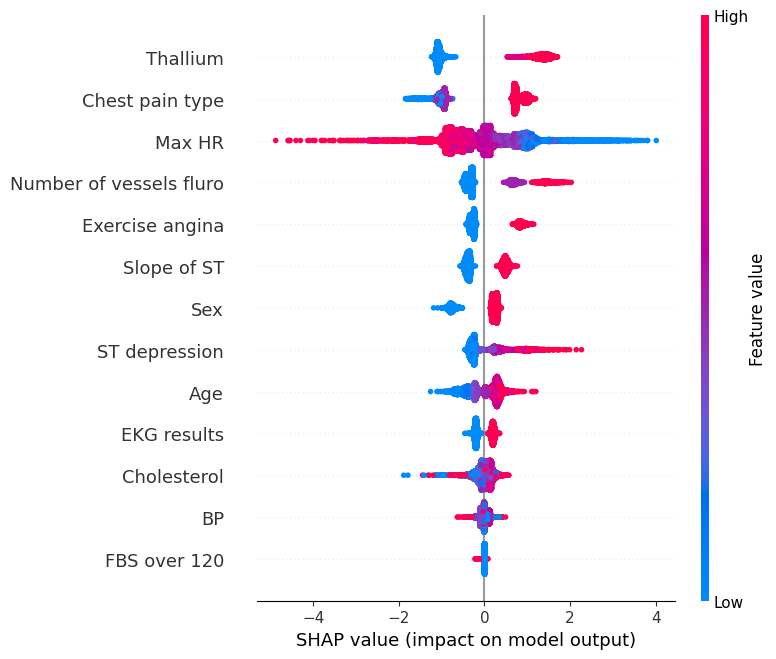

In [31]:
import shap
import matplotlib.pyplot as plt

shap_data = e_aml.collectors['shap']._load_node_data('xgb1')
entry = shap_data[(0, 0)]
shap_values = entry['valid']
valid_index = entry['valid_index']
columns = entry['columns']

X_valid_shap = df_train.loc[valid_index, columns]

shap.summary_plot(shap_values, X_valid_shap, feature_names=columns, show=False)
plt.tight_layout()
plt.show()

## Feature Engineering 방향

| 구분 | 변수 | 근거 |
|------|------|------|
| **상위 예측력 (전 모델 공통)** | Thallium, Chest pain type, Number of vessels fluro, Exercise angina | SHAP/gain/CB 공통 상위권 |
| **연속형 상위** | Max HR, ST depression | SHAP/AUC 기준 단독 예측력 높음 |
| **연속형 중간** | Age, Cholesterol | CB interaction 상위 쌍으로 등장 |
| **하위 / 약한 예측력** | BP, FBS over 120, EKG results | 단독 AUC ≈ 0.5, IG 낮음 |

### 주요 방향
- **Interaction 파생**: CB interaction 상위 쌍(Cholesterol×Max HR, Age×Cholesterol, Age×Max HR 등) → 곱/비율 파생 고려
- **Chest pain type 이진화**: type 4 vs 나머지 분리 (0.697 vs 0.108~0.191)
- **Number of vessels fluro / Slope of ST**: 수치형 그대로 사용 (단조 증가 패턴 확인)
- **Thallium**: 빈도 낮은 6(1.7%) OOV 처리 검토 (CatOOVFilter)
- **FBS over 120**: 단독 효과 미미 → 우선 포함하되 interaction 검토 후 필요시 제거

# Feature Engineering

## ST depression Frequency Encoding

ST depression은 Cardinality가 66으로 크지 않고, 빈도가 낮은 값일수록 Presence 비율이 높음 (Spearman ρ=-0.664).
Frequency Encoding으로 희귀성 정보를 모델에 직접 전달.

In [32]:
from mllabs.processor import FrequencyEncoder, CategoricalPairCombiner
from sklearn.preprocessing import PolynomialFeatures

if e_aml.status == 'closed':
    e_aml.reopen_exp()

# ST depression Frequency Encoding
e_aml.set_node(
    'freq_st', grp='pre', processor=FrequencyEncoder,
    edges={'X': [(None, ['ST depression'])]}
)

# Categorical pair interactions
# Thallium x Chest pain type (IG 1,2위), Chest pain type x Exercise angina (강한 연관)
e_aml.set_node(
    'cat_pair', grp='pre', processor=CategoricalPairCombiner,
    edges={'X': [(None, X_nom + X_bin)]},
    params={
        'pairs': [
            ('Thallium', 'Chest pain type'),
            ('Chest pain type', 'Exercise angina'),
            ('Thallium', 'Exercise angina'),
        ],
        'min_frequency': 0,
    }
)

# Continuous interactions: CB interaction 상위 쌍 (Age, Cholesterol, Max HR)
e_aml.set_node(
    'cont_inter', grp='pre', processor=PolynomialFeatures,
    edges={'X': [(None, ['Age', 'Cholesterol', 'Max HR'])]},
    params={'degree': 2, 'include_bias': False, 'interaction_only': True}
)

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7e4854facd70>}

In [33]:
e_aml.pipeline.grps

{'pre': <mllabs._pipeline.PipelineGroup at 0x7e49d1e3eb70>,
 'clf': <mllabs._pipeline.PipelineGroup at 0x7e48cf9c6d80>,
 'xgb': <mllabs._pipeline.PipelineGroup at 0x7e4854f408f0>,
 'lgb': <mllabs._pipeline.PipelineGroup at 0x7e48cf9eea20>,
 'cb': <mllabs._pipeline.PipelineGroup at 0x7e48cf991610>,
 'lr': <mllabs._pipeline.PipelineGroup at 0x7e49d0c65e50>}

In [34]:
# 후보별 개별 실험 + 전체 조합
e_aml.set_node('xgb_freq',    grp='xgb', edges={'X': [(None, X_all), ('freq_st', None)]})
e_aml.set_node('xgb_cat',     grp='xgb', edges={'X': [(None, X_all), ('cat_pair', None)]}, params = {'enable_categorical': True})
e_aml.set_node('xgb_cont',    grp='xgb', edges={'X': [(None, X_all), ('cont_inter', None)]})
e_aml.set_node('xgb_all_fe',  grp='xgb', edges={'X': [(None, X_all), ('freq_st', None), ('cat_pair', None), ('cont_inter', None)]})

{'result': 'new',
 'affected_nodes': [],
 'old_obj': None,
 'obj': <mllabs._pipeline.PipelineNode at 0x7e488ed5deb0>}

In [35]:
e_aml.build()
e_aml.exp()

Building 3 node(s)
Build 1/1 (100%) freq_st 3/3 (100%)%)
Build complete: 3 node(s)
Experimenting 4 node(s)
Exp 0/1 (0%) > Node 0/4 (0%)[xgb_cat] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 0/1 (0%) > xgb_cont 2/4 (50%)[xgb_all_fe] Exp error at fold 0: AttributeError: 'DataFrame' object has no attribute 'dtype'
Exp 1/1 (100%) xgb_freq 4/4 (100%)> 500/1000 (50%) validation_0-auc: 0.9565
Experimentation complete: 2/4 node(s), 2 error(s): ['xgb_cat', 'xgb_all_fe']


In [36]:
e_aml.show_error_nodes()

[xgb_cat] AttributeError: 'DataFrame' object has no attribute 'dtype'
[xgb_all_fe] AttributeError: 'DataFrame' object has no attribute 'dtype'


In [37]:
nodes = ['xgb1', 'xgb_freq', 'xgb_cat', 'xgb_cont', 'xgb_all_fe']
e_aml.collectors['AUC'].get_metrics_agg(nodes)[0].sort_values('valid', ascending=False)

,valid
xgb1,0.954921
xgb_freq,0.954883
xgb_cont,0.954838
